In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Evaluation metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.decomposition import PCA


from scipy import stats
from collections import OrderedDict 

from IPython.core.interactiveshell import InteractiveShell  # print all outputs
InteractiveShell.ast_node_interactivity = "all"

plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['text.color'] = 'k'

%matplotlib inline

In [2]:
SEED = 1234
random.seed(SEED)

#### Loading data after Discretization

In [3]:
df_train = pd.read_csv("data/processed_discrete_data.csv")

In [4]:
target_variable = 'aircon_sum_target_next14d'
input_variables = df_train.columns[(df_train.columns!= target_variable) & (df_train.columns!= 'DATE') & (df_train.columns!= 'SITE_ID')]

X = df_train[input_variables]
y = df_train[target_variable]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=SEED, shuffle=True)
crossvalidation = StratifiedKFold(n_splits=10, shuffle=True)

# Baseline

## Majority Voting
First, let's check what is the class distribution. As we can see the dataset is quite imbalanced with only 0.6% of data points that have been classified as faulty. Thus, a very simple model classifying all the sites as not faulty would reach a 99.4% accuracy (an impressive result in many applications) however, it would be useless for the real goal of this analysis, that is, to create a model to identify the faulty cells.

In [6]:
print("Class %2d  %.1f%%\nClass %2d  %.1f%%\n"%((y.value_counts()/y.shape[0]).index[0], 100*(y.value_counts()/y.shape[0]).values[0],(y.value_counts()/y.shape[0]).index[1],100*(y.value_counts()/y.shape[0]).values[1]))

Class  0  99.4%
Class  1  0.6%



## Decision Tree

Since we have high dimensionality of the dataset and also a high correlation between features we decided to use DecisionTree.

In [7]:
methods = OrderedDict()

In [8]:
baseline = DecisionTreeClassifier(max_depth=None, random_state = SEED)

In [9]:
val_score = cross_validate(baseline, X, y, cv=crossvalidation, scoring=['recall','precision','f1'])
methods['DecisionTreeBaseline'] = val_score
print("Recall    %.3f"%val_score['test_recall'].mean())
print("Precision %.3f"%val_score['test_precision'].mean())
print("F1        %.3f"%val_score['test_f1'].mean())

Recall    0.659
Precision 0.672
F1        0.665


### Pruning
 To improve the performance on our validation-set we tried to apply a post-pruning technique without any success. 

In [10]:
path = baseline.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [11]:
# We have some ccp_aplhas < 0 while we need it >=0 to prune the tree
impurities = np.delete(impurities, np.where(ccp_alphas < 0))
ccp_alphas = ccp_alphas[ccp_alphas >= 0]
impurities.shape
ccp_alphas.shape

(819,)

(819,)

Text(0.5, 0, 'effective alpha')

Text(0, 0.5, 'total impurity of leaves')

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

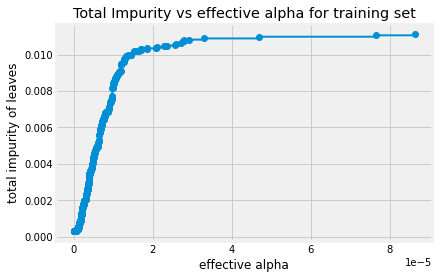

In [12]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

For the sake of simplicity we got just 19 ccp_alphas, so that we have to train just less models and have an idea of the performance

In [13]:
ccp_alphas[ccp_alphas < 0.000030].shape
760/40

(814,)

19.0

In [14]:
new_alphas = []
counter = 0
for alpha in ccp_alphas: 
    if((alpha < 0.000030) & (counter % 40 == 0)):
        new_alphas.append(alpha)
    elif(alpha > 0.000030):
        new_alphas.append(alpha)
    counter = counter + 1    

In [15]:
# Here we are extracting only 10 ccp_alphas randomly from new_alphas
random_alphas = []
for i in range (0,10):
    random_alphas.append(random.choice(new_alphas))
random_alphas.sort()

In [16]:
clfs = []
for ccp_alpha in random_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=SEED)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

DecisionTreeClassifier(random_state=1234)

DecisionTreeClassifier(ccp_alpha=1.6940658945086007e-21, random_state=1234)

DecisionTreeClassifier(ccp_alpha=6.765442121642648e-07, random_state=1234)

DecisionTreeClassifier(ccp_alpha=1.0148163182463973e-06, random_state=1234)

DecisionTreeClassifier(ccp_alpha=4.035102979694e-06, random_state=1234)

DecisionTreeClassifier(ccp_alpha=8.22686543987941e-06, random_state=1234)

DecisionTreeClassifier(ccp_alpha=3.287826027773802e-05, random_state=1234)

DecisionTreeClassifier(ccp_alpha=4.702479002469318e-05, random_state=1234)

DecisionTreeClassifier(ccp_alpha=8.641407792650546e-05, random_state=1234)

DecisionTreeClassifier(ccp_alpha=0.00028704340770116, random_state=1234)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.00028704340770116


Text(0.5, 0, 'alpha')

Text(0, 0.5, 'number of nodes')

Text(0.5, 1.0, 'Number of nodes vs alpha')

Text(0.5, 0, 'alpha')

Text(0, 0.5, 'depth of tree')

Text(0.5, 1.0, 'Depth vs alpha')

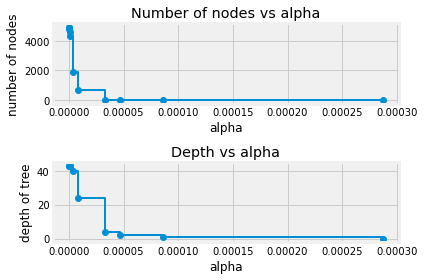

In [17]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(random_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(random_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

We see in the plot above that increasing alpha means a stronger pruning

In [18]:
train_scores = []
test_scores = []
for clf in clfs:
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_scores.append(recall_score(y_train,y_train_pred))
    test_scores.append(recall_score(y_test,y_test_pred))

Text(0.5, 0, 'alpha')

Text(0, 0.5, 'recall')

Text(0.5, 1.0, 'Recall vs alpha for training and testing sets')

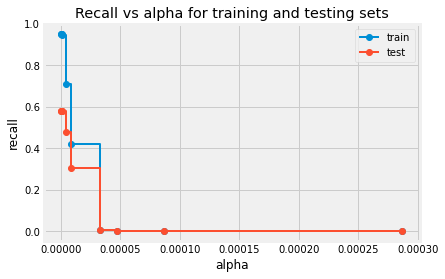

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(random_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(random_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In the plot above we see that pruning will lead to worse performances. \
Since our baseline has a really high depth due to the high dimentionality of the dataset, \
it is likely that it overfits and we need to reduce the numbers of features with Feature selection


## Selection by manual inspection

Looking at the correlation matrix of the attributes we saw high correlated features and some features data points already contained in others. \
For instance, all mean/max/min_w_prev3d are contained in mean/max/min_w_prev7d and mean/max/min_w_f_next7d are contained in mean/max/min_w_f_next14d and \
the averages 
over a long period are more smooth and get less variations.


Rain isn't deleted because we don't see a high correlation and instead the scatter plot showed us high variance from previous7days and previous3days

In [10]:
ms_to_delete = []

alarms = ['equipment', 'fire/smoke', 'ge', 'power', 'temperature']
weathers = ['temperature', 'humidity', 'wind_speed', 'pressure']
operators = ['mean', 'max', 'min']

#sum
for d in ['7', '3']:
    for a in alarms:
        ms_to_delete.append(a + '_sum_alarms_prev'+ d +'d')

#weather prev
for w in weathers:
    for o in operators:
        ms_to_delete.append(o + '_' + w + '_prev3d')
        
#weather future
for w in weathers:
    for o in operators:
        ms_to_delete.append(o + '_' + w + '_f_next7d')

#persistance
for a in alarms:
    for o in operators:
        ms_to_delete.append(a + '_' + o +'_persistance_prev3d')


print("We are going to remove " +str(len(ms_to_delete))+ " attributes")

We are going to remove 49 attributes


In [11]:
df_man_sel = X.drop(ms_to_delete, axis=1)

In [12]:
val_score = cross_validate(baseline, df_man_sel, y, cv=crossvalidation, scoring=['recall','precision','f1'])
methods['ManualSelection'] = val_score
print("Recall    %.3f"%val_score['test_recall'].mean())
print("Precision %.3f"%val_score['test_precision'].mean())
print("F1        %.3f"%val_score['test_f1'].mean())

Recall    0.695
Precision 0.697
F1        0.696


## SelectKBest

F_classif score computes the F-score, which is a value that represents how well a feature discriminates between the two classes

In [24]:
from sklearn.feature_selection import SelectKBest,f_classif

bestfeatures = SelectKBest(score_func=f_classif, k=50)
bestfit = bestfeatures.fit(X, y)

In [25]:
pd.options.display.max_columns = df_train.shape[1]

df_kBest = pd.DataFrame({'Feature': list(X.columns), 'Scores': bestfit.scores_})
df_kBest = df_kBest.sort_values(by='Scores',ascending = False).head(50)

kBest_features = df_kBest['Feature']
df_kBest = X[kBest_features]

Testing the performance of the feature selection suggested by SelectKBest

In [26]:
val_score = cross_validate(baseline, df_kBest, y, cv=crossvalidation, scoring=['recall','precision','f1'])
methods['SelectKBest'] = val_score
print("Recall    %.3f"%val_score['test_recall'].mean())
print("Precision %.3f"%val_score['test_precision'].mean())
print("F1        %.3f"%val_score['test_f1'].mean())

Recall    0.471
Precision 0.581
F1        0.520


## Feature Importances
Let's use 3 main algorithm to look for the feature_importance : Ada_Boost, Random_Forest, Decision_Trees

In [13]:
n_estimators = 40
feature_importance_model = {
    'Decision Tree':DecisionTreeClassifier(max_depth=5, random_state=SEED),
    'Random Forest':RandomForestClassifier(n_estimators=n_estimators,max_depth=3,oob_score=False),
    'Ada Boost':AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, random_state=SEED), n_estimators=n_estimators)}
clf = {}
for name in feature_importance_model :
    clf[name] = feature_importance_model[name]
    clf[name].fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1234)

RandomForestClassifier(max_depth=3, n_estimators=40)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1234),
                   n_estimators=40)

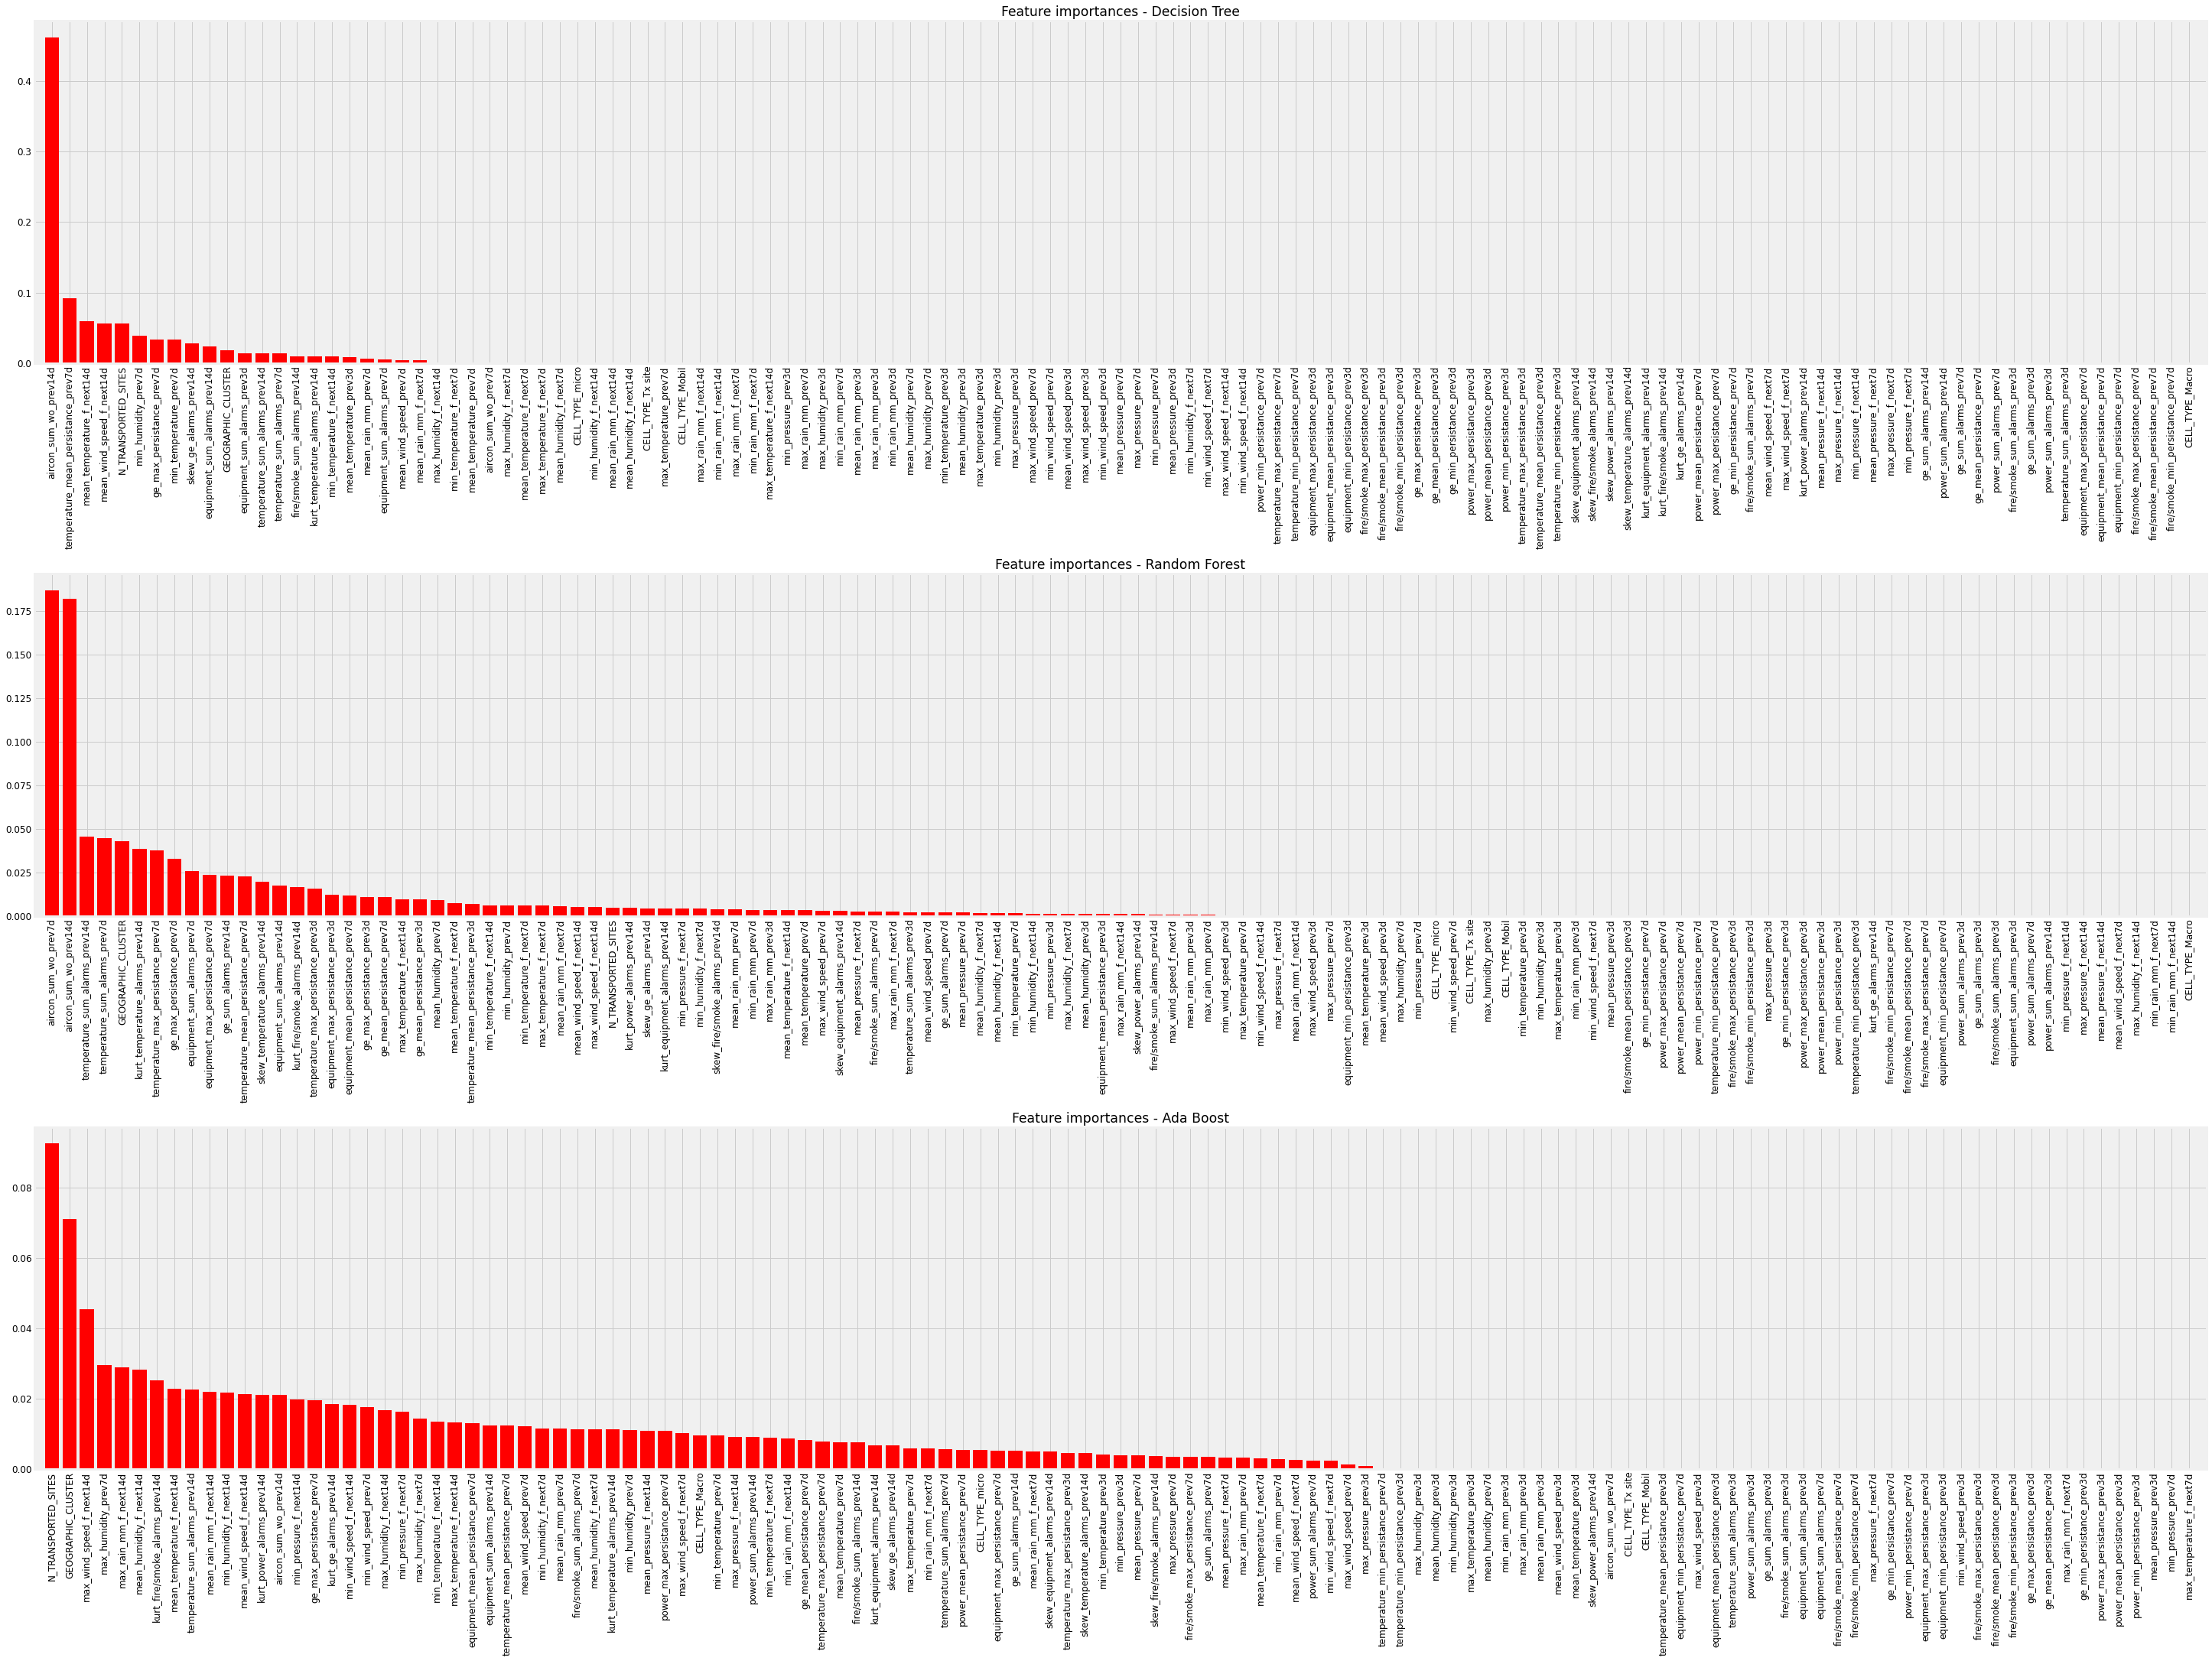

In [28]:
plot_idx = 1
plt.subplots(len(feature_importance_model),1,figsize=(40,10*len(feature_importance_model)))
font = {'family' : 'sans', 'size'   : 12}
plt.rc('font', **font)

feature_importances = []

for model_name in feature_importance_model:
    model = feature_importance_model[model_name]
    
    # importance of features
    importances = model.feature_importances_
    # indeces of the variables
    indices = np.argsort(importances)[::-1]
    feature_importances.append(X.columns[indices[:20]])
    
    plt.subplot(len(feature_importance_model),1,plot_idx)
    plt.title("Feature importances - "+model_name)
    plt.xticks(range(X.shape[1]),X.columns[indices],rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.bar(range(X.shape[1]), importances[indices], color="r")
    plot_idx = plot_idx + 1

plt.tight_layout(pad=0.1, w_pad=1, h_pad=1)
plt.show();

In [29]:
# take the union of the 20 most relevant features detected by the models
common_importances = []
for index_list in feature_importances:
    for item in index_list:
        if item not in common_importances:
            common_importances.append(item)

In [30]:
df_importances = X[common_importances]

In [31]:
val_score = cross_validate(baseline, df_importances, y, cv=crossvalidation, scoring=['recall','precision','f1'])
methods['FeatureImportances'] = val_score
print("Recall    %.3f"%val_score['test_recall'].mean())
print("Precision %.3f"%val_score['test_precision'].mean())
print("F1        %.3f"%val_score['test_f1'].mean())

Recall    0.655
Precision 0.692
F1        0.672


## Principal Component Analysis

We now apply principal component analysis. Since we need to decide how many component to select and for this purpose we apply PCA and plot the explained variance ratio and the cumulative explained variance. Note that to apply PCA we first need to normalize the data, which in this case we do by applying z-score normalization.

In [32]:
X_std = StandardScaler().fit_transform(X)
feature_selection_pca_model = PCA(n_components=50)
pca_model = DecisionTreeClassifier(random_state=SEED)

fitted_model = feature_selection_pca_model.fit(X_std)

X_selected_features_pca = fitted_model.transform(X_std)

print("Explained Variance = %.3f" % fitted_model.explained_variance_ratio_.cumsum()[-1])
print("Reduced data set shape =",X_selected_features_pca.shape)

Explained Variance = 0.942
Reduced data set shape = (615875, 50)


In [ ]:
pca_score_dic = {'test_recall': [0.238] , 'test_precision' : [0.224] , 'test_f1' :[0.231] }
methods['PCA_wholeDataset'] = pca_score_dic

With using just the first five principal components as input variables, we reach the same performance as the one obtained with all the variables. However, the standard deviation is much higher than in the previous cases. The components are linear combinations of the original variables accordingly, when building a model using these new features we lose the connection with the original variables. For this purpose, it might interesting to check the weights that each component assigns to each original variable.

## Comparing methods

In [34]:
method_names = methods.keys()

In [35]:
recalls = []
recalls_std = []
precisions = []
f1s = []
for m in methods:
    recalls.append(methods[m]['test_recall'].mean())
    recalls_std.append(methods[m]['test_recall'].std())
    precisions.append(methods[m]['test_precision'].mean())
    f1s.append(methods[m]['test_f1'].mean())

In [36]:
recall_df = pd.DataFrame({'Method': list(method_names), 'Recall_score (mean)' : recalls, 'Recall_score (std)': recalls_std})
f1_df = pd.DataFrame({'Method': list(method_names), 'F1_score (mean)' : f1s})

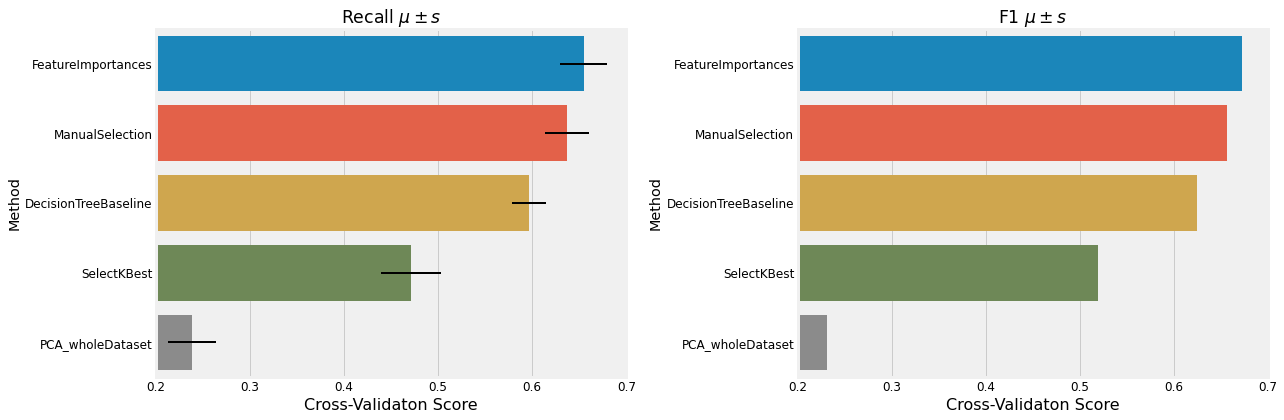

In [37]:
f, axe = plt.subplots(1,2, figsize=(18,6))
# Recall plot
recall_df.sort_values(by=['Recall_score (mean)'], ascending=False, inplace=True)
sns.barplot(x='Recall_score (mean)', y='Method', data = recall_df, xerr=recall_df['Recall_score (std)'], ax = axe[0])
axe[0].set_xlabel('Cross-Validaton Score', size=16)
axe[0].set_ylabel('Method')
axe[0].set_title("Recall $\mu\pm s$")
axe[0].set_xlim(0.2,0.7)

# F1 plot
f1_df.sort_values(by=['F1_score (mean)'], ascending=False, inplace=True)
sns.barplot(x='F1_score (mean)', y='Method', data = f1_df, ax = axe[1])
axe[1].set_xlabel('Cross-Validaton Score', size=16)
axe[1].set_ylabel('Method')
axe[1].set_title("F1 $\mu\pm s$")
axe[1].set_xlim(0.2,0.7)
plt.tight_layout()
plt.show();

The best scenario is that our accuracy is similar in all our folds, for instance 92.0, 91.5, 92.0, 92.5 and 91.8. 
This means that our algorithm (and our data) is consistent and we can be confident that by training it on all the dataset and deploy it in production will lead to similar performance.


High variance    ---> our data is inconsistent or algorithm is unable to learn

### Let's verify that the performace difference of the top 3 models is statistically significant

In [39]:
df_crossvalidation = pd.DataFrame({'DecisionTreeBaseline': methods['DecisionTreeBaseline']['test_recall'],
                   'ManualSelection': methods['ManualSelection']['test_recall'],
                   'FeatureImportances' : methods['FeatureImportances']['test_recall']})

In [40]:
df_crossvalidation

,DecisionTreeBaseline,ManualSelection,FeatureImportances
0,0.620112,0.631285,0.594972
1,0.611732,0.650838,0.678771
2,0.603352,0.594972,0.636872
3,0.568245,0.646240,0.657382
4,0.596100,0.604457,0.674095
5,0.603352,0.634078,0.645251
6,0.617318,0.636872,0.673184
7,0.600559,0.656425,0.684358
8,0.564246,0.681564,0.648045
9,0.583799,0.634078,0.653631


In [41]:
confidence_level = 0.95

no_variables = len(df_crossvalidation.columns)

p_value = np.zeros((no_variables,no_variables))

for first,first_model in enumerate(df_crossvalidation.columns):
    
    p_value[first,first] = 1.0
    
    for second in range(first+1,(len(df_crossvalidation.columns))):

        second_model = df_crossvalidation.columns[second]
        
        paired_test = stats.ttest_rel(df_crossvalidation[first_model], df_crossvalidation[second_model])
    
        p_value[first,second] = paired_test[1]
        p_value[second,first] = paired_test[1]
        
        if (paired_test[1]<(1-confidence_level)):
            print("%15s vs %15s => Difference is statistically significant (cf %3.2f p-value=%.4f)"%(first_model,second_model,confidence_level*100,paired_test[1]))
        else: 
            print("%15s vs %15s => Difference is NOT statistically significant (cf %3.2f p-value=%.4f)"%(first_model,second_model,confidence_level*100,paired_test[1]))

DecisionTreeBaseline vs ManualSelection => Difference is statistically significant (cf 95.00 p-value=0.0077)
DecisionTreeBaseline vs FeatureImportances => Difference is statistically significant (cf 95.00 p-value=0.0005)
ManualSelection vs FeatureImportances => Difference is NOT statistically significant (cf 95.00 p-value=0.1208)


\
We found out that the difference between FeatureImportances and ManualSelection methods is not statistically significant. Thus, we chose to train our model with both and preserve the best performances.


In [15]:
df_man_sel['aircon_sum_target_next14d'] = y

In [16]:
df_man_sel

,N_TRANSPORTED_SITES,GEOGRAPHIC_CLUSTER,aircon_sum_wo_prev7d,aircon_sum_wo_prev14d,mean_temperature_prev7d,max_temperature_prev7d,min_temperature_prev7d,mean_rain_mm_prev7d,max_rain_mm_prev7d,min_rain_mm_prev7d,...,skew_ge_alarms_prev14d,skew_power_alarms_prev14d,skew_temperature_alarms_prev14d,kurt_equipment_alarms_prev14d,kurt_fire/smoke_alarms_prev14d,kurt_ge_alarms_prev14d,kurt_power_alarms_prev14d,kurt_temperature_alarms_prev14d,CELL_TYPE,aircon_sum_target_next14d
0,3.0,8,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,0,0
1,3.0,8,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,0,0
2,3.0,8,0.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,0,0
3,3.0,8,0.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,0,0
4,3.0,8,0.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.212308,-1.212308,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615870,7.0,9,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,0,0
615871,7.0,9,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,0,0
615872,7.0,9,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,0,0
615873,7.0,9,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-1.212308,-1.212308,-1.212308,-1.210000,-1.212308,0,0


In [17]:
df_man_sel.to_csv('data/data_to_predict.csv',index=False)